# AKI Seminar2 Demo
In Seminar 2, our focus will be on a practical demonstration of tuning the LLaMA model developed by Meta AI, as outlined in their paper. The LLaMA model is a cutting-edge technology that leverages advanced machine learning techniques, and our goal is to provide a hands-on experience for understanding its tuning process. During the demo, we will delve into the key components of the LLaMA model, emphasizing the significance of parameter tuning in optimizing its performance. We'll explore how to adjust hyperparameters, fine-tune model architectures, and optimize training parameters to achieve superior results. Attendees will have the opportunity to actively engage in the tuning process, providing them with a hands-on understanding of the nuances involved in refining the LLaMA model for various applications. By the end of the seminar, participants will not only comprehend the theoretical foundations of the LLaMA model but will also possess practical skills to navigate its tuning process, enabling them to apply this knowledge in their own machine learning endeavors.


## Finetuning of LLaMA-7B-Model for Text Classification
In this notebook we will finetune the llama-7B-Model for Text Classifiction. We will classify the sentiment on imdb reviews.

![LLaMA Architecture](https://images.datacamp.com/image/upload/v1700044736/image9_02d9fcb498.png)

**Table of contents:**

- 1. Check for GPU
- 2. Install packages   
- 3. Import libaries  
- 4. Load LLaMA-7B-Model
- 5. Load Tokenizer
- 6. Prepare dataset for finetuning
- 8. Load model and configure Trainer for easier finetuning
- 9. Finetune the model
- 10. Save and load model
- 11. Example Classifying
- 12. Implement User Interface via Gradio Libary


**Resources**:
- [Meta AI Paper: LLaMA: Open and Efficient Foundation Language Models](#https://arxiv.org/abs/2302.13971)
- [Hugging Face Libary](#https://huggingface.co/)

------------
### 1. Check for GPU

In [80]:
!nvidia-smi

Fri Jan 19 14:16:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              51W / 400W |  26045MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

--------------
### 2. Install packages

In [1]:
!pip install accelerate --quiet
!pip install bitsandbytes --quiet
!pip install datasets --quiet
!pip install -q gradio --quiet
!pip install -q git+https://github.com/huggingface/peft.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [82]:
!pip install sentencepiece
!pip install accelerate --quiet

We will load and fine tune the llama-7B-Model with the hugging Face libary.
![Hugging Face Logo](https://huggingface.co/datasets/huggingface/brand-assets/resolve/main/hf-logo-with-title.png)



---------------
### 3. Import libaries

In [31]:
import numpy as np
import pandas as pd
import torch
import transformers
import gradio as gr
from datasets import load_dataset
from peft import LoraConfig, TaskType
from peft import get_peft_model
from accelerate import Accelerator
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorWithPadding, DataCollatorForSeq2Seq, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:0'

-----------------
### 4. Load LLaMA-7B-Model


**Resources**:
- [Hugging Face: datasets tutorial](#https://huggingface.co/docs/datasets/tutorial)
- [Hugging Face: LLaMA-7B-Model](https://huggingface.co/docs/transformers/main/model_doc/llama)
- [Hugging Face: 7B Weights](#https://huggingface.co/huggyllama/llama-7b)   

**Note**: I use a model that has the weights in it and we introduce these into the actual LLaMA model. Normally you have to request the weights from Meta AI by filling out a form. I have filled it out several times but there is no response from them.

----------------
### 5. Load Tokenizer

In [5]:
#MODEL_NAME= "TheBloke/Llama-2-7B-GPTQ"
#MODEL_NAME = 'huggyllama/llama-7b'
#MODEL_NAME = "baffo32/decapoda-research-llama-7B-hf"
MODEL_NAME = "Enoch/llama-7b-hf"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token_id = (0)
tokenizer.padding_side = "left"

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### 6. Load dataset

**Description**:  
We will use the imdb dataset to finetune the llama model for text classification

**Resources**:
- [Hugging Face: imdb dataset](#https://huggingface.co/datasets/imdb)
- [Hugging Face: Data Collator](#https://huggingface.co/docs/transformers/main_classes/data_collator)

- [Hugging Face: AutoModels](#https://huggingface.co/transformers/v3.0.2/model_doc/auto.html)
- [Hugging Face: LoRA=(Low-Rank Adaptation of Large Language Models)](#https://huggingface.co/docs/peft/conceptual_guides/lora)
- [Hugging Face: PEFT=(Parameter-Efficient Fine-Tuning)](#https://huggingface.co/docs/peft/index)
- [Hugging Face: Trainer API](#https://huggingface.co/docs/transformers/main_classes/trainer)

The imdb dataset is already splitted in train and test data. We need only to make it for finetunig ready.

In [7]:
dataset = load_dataset("imdb")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

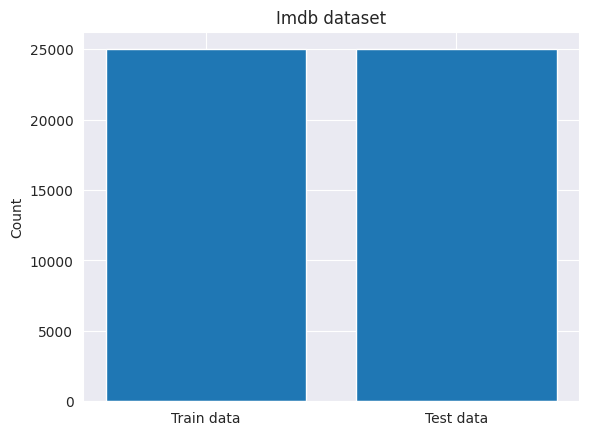

In [46]:
fig, ax = plt.subplots()

number_of_train = len(dataset["train"]["text"])
number_of_test = len(dataset["train"]["text"])
number_of_unsupervised = len(dataset["unsupervised"]["text"])

ax.bar(["Train data", "Test data"], [number_of_train, number_of_test])
ax.set(title="Imdb dataset", ylabel="Count")
plt.show()

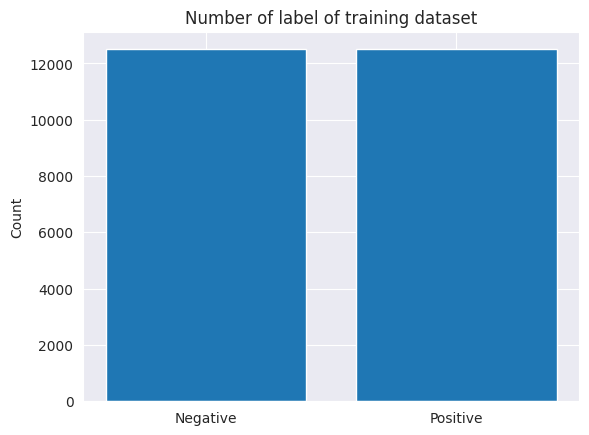

In [48]:
fig, ax = plt.subplots()
number_of_zeros = dataset["train"]["label"].count(0)
number_of_ones = dataset["train"]["label"].count(1)
ax.bar(["Negative", "Positive"], [number_of_zeros, number_of_ones])
ax.set(title="Number of label of training dataset", ylabel="Count")
plt.show()

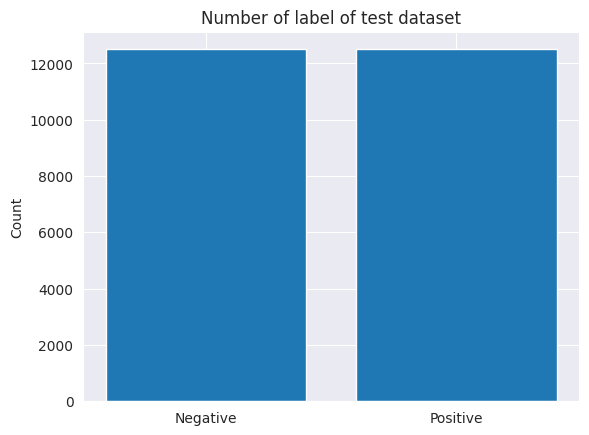

In [49]:
fig, ax = plt.subplots()
number_of_zeros = dataset["test"]["label"].count(0)
number_of_ones = dataset["test"]["label"].count(1)
ax.bar(["Negative", "Positive"], [number_of_zeros, number_of_ones])
ax.set(title="Number of label of test dataset", ylabel="Count")
plt.show()

In [54]:
dataset["train"]["text"][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [55]:
dataset["train"]["label"][0]

0

-------
### 7. Prepare dataset for finetuning

We define a preprocessing function to tokenize our dataset.

In [8]:
def preprocess_function(examples):
  """
  A function to tokenize text.

  :param examples: Given text.
  :type examples: str

  :return: tokenized text
  :rtype: list[int]
  """
  return tokenizer(examples["text"], truncation=True)

With the Dataset Class from hugging face we can map to entire dataset.

In [9]:
tokenized_imdb = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Size of dataset is 25k. We reduce it to 1000 to speed up the training.

In [10]:
tokenized_imdb_train = tokenized_imdb["train"].select(range(1000))
tokenized_imdb_train

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 10
})

In [11]:
tokenized_imdb_test = tokenized_imdb["test"].select(range(1000))
tokenized_imdb_test

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 10
})

We use the data Collator Class from Hugging Face to make batching and other preproccessing task like: padding easier. It takes us this job!

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Define target labels

In [58]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

Load the model

---------
### 8. Load model and configure Trainer for easier finetuning

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, id2label=id2label, label2id=label2id)


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at Enoch/llama-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Define Lora config to instance the peft model for more efficient training

In [15]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM

)

Use the PEFT-Model to reduce computational and storage costs just only training a small number of (extra) model parameters

In [16]:
lora_model = get_peft_model(model=model, peft_config=lora_config)
lora_model.print_trainable_parameters()

trainable params: 4,194,304 || all params: 6,611,546,112 || trainable%: 0.06343907958816639


Deactivate saving caches for speed up

In [17]:
lora_model.config.use_cache = False

We will use the Trainer API provided from Hugging Face. This Trainer takes the work of defining own training pipeline and can adjust the resources more effeciently according to the current ram. It takes most of work.
Define Training Argument and for the Trainer class.

In [56]:
training_args = TrainingArguments(
    learning_rate=3e-4,
    gradient_accumulation_steps=20,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    fp16=False,
    evaluation_strategy="steps",
    save_strategy="steps",
    optim="adafactor",
    output_dir="./content/experiments",
    load_best_model_at_end=True
)

We over give the model the model, training_arguments, the train/test dataset and the data_collator.

In [19]:
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_imdb_train,
    eval_dataset=tokenized_imdb_test,
    data_collator=data_collator
)

Empty cache.

In [20]:
torch.cuda.empty_cache()

----------------
### 9. Finetune the model

In [21]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=1, training_loss=0.8539467453956604, metrics={'train_runtime': 7.6465, 'train_samples_per_second': 1.308, 'train_steps_per_second': 0.131, 'total_flos': 132551617486848.0, 'train_loss': 0.8539467453956604, 'epoch': 1.0})

----------
### 10. Save and load model

In [22]:
lora_model.save_pretrained("./content/llama_7b", from_pt=True)

In [23]:
trained_model = AutoModelForSequenceClassification.from_pretrained("./content/llama_7b")

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at Enoch/llama-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


----------------
### 11. Example Classifying

In [24]:
text = "This was a masterpiece. Not completely faithful to the books, but enthralling from beginning to end. Might be my favorite of the three."

In [25]:
inputs = tokenizer(text, return_tensors="pt")

In [26]:
with torch.no_grad():
  output = trained_model(**inputs).logits


In [59]:
predicted_class_id = output.argmax().item()
trained_model.config.id2label[predicted_class_id]

'LABEL_0'

-----------
### 12. Implement User Interface via Gradio Libary

In [28]:
def user_interface(message, history):
  """
  A function to to display chat to interact with the model.

  :param message: Given message from the use.
  :type message: str

  :param history: Given history of the chat.
  :type history: list[str]

  :return: Classification of the model.
  :rtype: str
  """
  inputs = tokenizer(message, return_tensors="pt")
  with torch.no_grad():
    output = trained_model(**inputs).logits

  predicted_class_id = output.argmax().item()
  sentiment = trained_model.config.id2label[predicted_class_id]
  return f'LLaMA-7B-Model says: {sentiment}'



gr.ChatInterface(fn=user_interface).launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d8c20da1dfa1b38d0e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
